In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

**Data Exploration**

In [ ]:
df = pd.read_csv('New york Sensors.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.drop(df.tail(1).index,inplace=True)

In [ ]:
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503910 entries, 0 to 503909
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   time                503910 non-null  datetime64[ns]
 1   use [kW]            503910 non-null  float64       
 2   gen [kW]            503910 non-null  float64       
 3   House overall [kW]  503910 non-null  float64       
 4   Dishwasher [kW]     503910 non-null  float64       
 5   Furnace 1 [kW]      503910 non-null  float64       
 6   Furnace 2 [kW]      503910 non-null  float64       
 7   Home office [kW]    503910 non-null  float64       
 8   Fridge [kW]         503910 non-null  float64       
 9   Wine cellar [kW]    503910 non-null  float64       
 10  Garage door [kW]    503910 non-null  float64       
 11  Kitchen 12 [kW]     503910 non-null  float64       
 12  Kitchen 14 [kW]     503910 non-null  float64       
 13  Kitchen 38 [kW]     503910 no

In [ ]:
df.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,0.014139,0.002755,0.007023,0.000009,0.058530,0.015642,0.010983,0.035313,0.076229,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936,202.356843,0.002598,38.694013,0.056453
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199,0.057967,0.014292,0.021860,0.076740,0.000010,0.202706,0.137841,0.098859,0.096056,0.128428,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,0.000500,0.000017,0.000000,0.029833,0.000983,0.003617,0.001483,0.003367,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000,148.000000,0.000000,24.600000,0.000000
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,0.000667,0.000050,0.000017,0.031317,0.001000,0.004000,0.001617,0.004283,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000,208.000000,0.000000,39.030000,0.000000
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,0.013100,0.000750,0.000167,0.000017,0.032883,0.001017,0.004067,0.001750,0.083917,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000,295.000000,0.000000,54.790000,0.000000
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,1.166583,2.262583,0.000183,7.027900,1.633017,1.929800,0.465217,0.613883,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.490000,0.840000


In [ ]:
df['time'] = pd.to_datetime(df['time'],unit='s')

In [ ]:
del df[df.columns[-1]]

In [ ]:
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483
1,2016-01-01 05:00:01,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467
2,2016-01-01 05:00:02,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467
3,2016-01-01 05:00:03,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483
4,2016-01-01 05:00:04,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467


In [ ]:
no_of_feature = len(df.columns)
no_of_feature

18

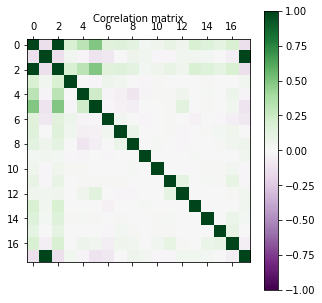

In [ ]:
# Correlations matrix of original data
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [ ]:
df = df.set_index('time')

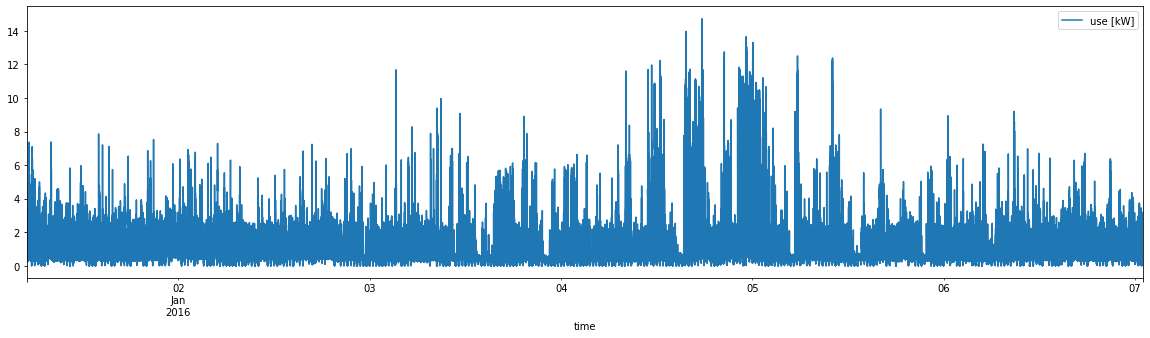

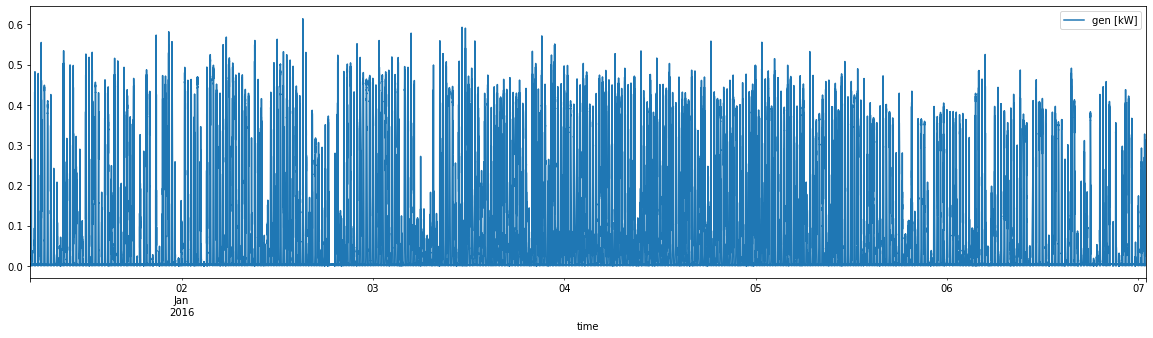

In [ ]:
#plotting all columns with respect to time for original data
for j in range(0,2):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

In [ ]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

use [kW]              0
gen [kW]              0
House overall [kW]    0
Dishwasher [kW]       0
Furnace 1 [kW]        0
Furnace 2 [kW]        0
Home office [kW]      0
Fridge [kW]           0
Wine cellar [kW]      0
Garage door [kW]      0
Kitchen 12 [kW]       0
Kitchen 14 [kW]       0
Kitchen 38 [kW]       0
Barn [kW]             0
Well [kW]             0
Microwave [kW]        0
Living room [kW]      0
Solar [kW]            0
dtype: int64

In [ ]:
from pandas import DataFrame
from pandas import concat
# convert series to supervised learning
def series_to_supervised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
from math import sqrt
from sklearn.model_selection import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [ ]:
reframed = series_to_supervised(scaled, 1, 1)

In [ ]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t)
1,0.063395,0.005674,0.063395,0.000024,0.010694,0.077812,0.455455,0.145775,0.005469,0.011999,0.000357,0.000066,0.000000,0.004461,0.000623,0.002107,0.003260,0.005674,0.063497,0.005647,0.063497,0.000000,0.010703,0.080202,0.456930,0.145598,0.005469,0.012030,0.000357,0.000066,0.000000,0.004482,0.000623,0.002107,0.003547,0.005647
2,0.063497,0.005647,0.063497,0.000000,0.010703,0.080202,0.456930,0.145598,0.005469,0.012030,0.000357,0.000066,0.000000,0.004482,0.000623,0.002107,0.003547,0.005647,0.063326,0.005647,0.063326,0.000012,0.010694,0.078315,0.458988,0.145050,0.005469,0.011999,0.000371,0.000074,0.091091,0.004485,0.000612,0.002107,0.003547,0.005647
3,0.063326,0.005647,0.063326,0.000012,0.010694,0.078315,0.458988,0.145050,0.005469,0.011999,0.000371,0.000074,0.091091,0.004485,0.000612,0.002107,0.003547,0.005647,0.069458,0.005674,0.069458,0.000012,0.055264,0.086115,0.459520,0.144580,0.005469,0.011923,0.000371,0.000096,0.000000,0.004482,0.000623,0.002107,0.003475,0.005674
4,0.069458,0.005674,0.069458,0.000012,0.055264,0.086115,0.459520,0.144580,0.005469,0.011923,0.000371,0.000096,0.000000,0.004482,0.000623,0.002107,0.003475,0.005674,0.077433,0.005647,0.077433,0.000095,0.122497,0.080412,0.459468,0.144247,0.005364,0.011724,0.000386,0.000147,0.000000,0.004482,0.000623,0.002107,0.003403,0.005647
5,0.077433,0.005647,0.077433,0.000095,0.122497,0.080412,0.459468,0.144247,0.005364,0.011724,0.000386,0.000147,0.000000,0.004482,0.000623,0.002107,0.003403,0.005647,0.094591,0.005593,0.094591,0.000202,0.260194,0.080013,0.459983,0.143601,0.005259,0.011402,0.000414,0.000250,0.000000,0.004475,0.000623,0.002107,0.003403,0.005593


In [ ]:
len(reframed.columns)

36

In [ ]:
values = reframed.values

In [ ]:
X = values[:,:21]
Y = values[:,21]

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3)

# reshape input to be 3D [samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

In [ ]:
# network architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit
history = model.fit(X_Train, Y_Train, epochs=70, batch_size=10, validation_data=(X_Test, Y_Test), verbose=2, shuffle=False)

In [ ]:
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [ ]:
lstm_test_mse = model.evaluate(X_Test, Y_Test, batch_size=1)
print('Test MSE: %f'%lstm_test_mse)

In [ ]:
from sklearn.metrics import r2_score

y_pred_test_lstm = model.predict(X_Test)
y_train_pred_lstm = model.predict(X_Train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_Train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_Test, y_pred_test_lstm)))

In [ ]:
lstm_y_pred_test = model.predict(X_Test)
plt.figure(figsize=(10, 6))
plt.plot(Y_Test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Appliances scaled')
plt.legend()
plt.show();

In [ ]:
# make a prediction
yhat = model.predict(X_Test)
X_Test = X_Test.reshape((X_Test.shape[0], 21))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_Test[:, -21:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
Y_Test = Y_Test.reshape((len(Y_Test), 1))
inv_y = np.concatenate((Y_Test, X_Test[:, -21:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)